In [1]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
from phrosty import plotting

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import roman_util, util
from mejiro.helpers import psf

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
band = 'F129'
detector = 1
detector_position = (2048, 2048)
oversample = 5

psf_1 = psf.get_psf_kernel(band, detector, detector_position, 1)

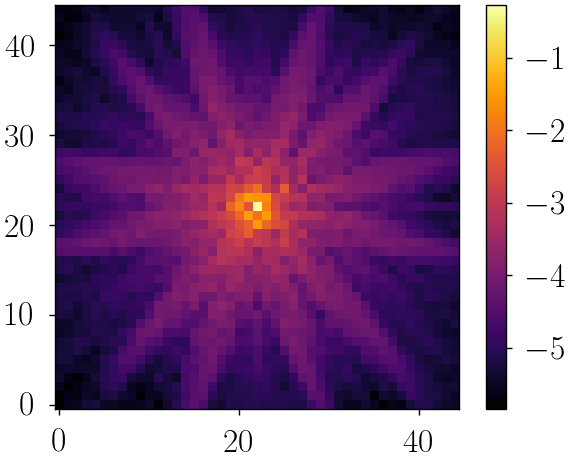

In [3]:
plt.imshow(np.log10(psf_1), cmap='inferno')
plt.colorbar()
plt.show()

In [4]:
# check normalization
print(f'{np.sum(psf_1):.2f}')

1.00


In [5]:
sides = 4
scas = range(1, 19)
sca_positions = roman_util.divide_up_sca(sides)

psf_id_strings = []
for sca in scas:
    for position in sca_positions:
        psf_id_strings.append(psf.get_psf_id_string(band, sca, position, oversample))

transmission = []
for psf_id_string in tqdm(psf_id_strings):
    interp = psf.load_cached_psf(psf_id_string, psf_cache_dir='/data/bwedig/mejiro/cached_psfs', suppress_output=True)
    kernel = psf.interpolated_image_to_kernel(interp, oversample)
    transmission.append(np.sum(kernel))

100%|██████████| 288/288 [00:04<00:00, 64.02it/s]


In [6]:
print(transmission)

[0.9729816, 0.9729717, 0.97296154, 0.97295064, 0.9729816, 0.97297037, 0.97295976, 0.9729515, 0.97298175, 0.9729703, 0.9729606, 0.97295237, 0.9729817, 0.97297263, 0.9729631, 0.9729532, 0.973057, 0.97305405, 0.97305083, 0.97304714, 0.9730573, 0.97305405, 0.97305083, 0.9730493, 0.9730575, 0.9730543, 0.9730526, 0.9730514, 0.9730576, 0.97305644, 0.973055, 0.97305334, 0.9728917, 0.9728919, 0.9728907, 0.9728883, 0.9728917, 0.972893, 0.97289157, 0.9728898, 0.97289145, 0.9728932, 0.9728931, 0.97289133, 0.97289133, 0.97289336, 0.9728938, 0.97289276, 0.97194755, 0.971941, 0.97193384, 0.971926, 0.9719448, 0.97193867, 0.97193164, 0.9719247, 0.97194207, 0.97193587, 0.9719296, 0.971923, 0.9719392, 0.9719334, 0.9719274, 0.9719209, 0.972701, 0.97270167, 0.97270215, 0.9727021, 0.97270083, 0.97270465, 0.9727051, 0.97270536, 0.9727005, 0.9727044, 0.9727081, 0.9727087, 0.97270024, 0.9727043, 0.9727081, 0.97271156, 0.9726854, 0.97269523, 0.972692, 0.97267586, 0.9726821, 0.9726992, 0.972695, 0.9726805, 0.972

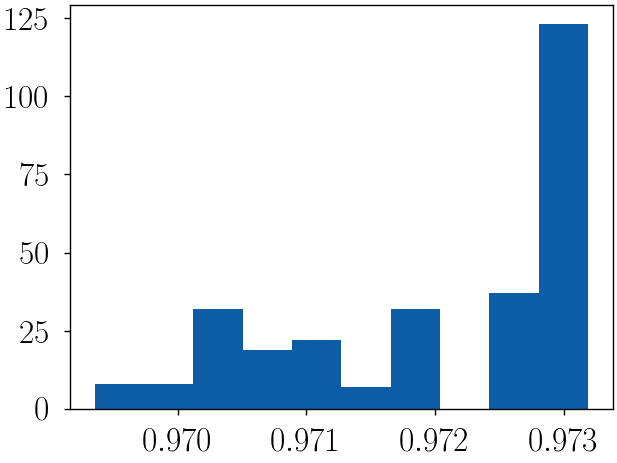

In [7]:
plt.hist(transmission)
plt.show()

In [8]:
transmission = [t * 100 for t in transmission]

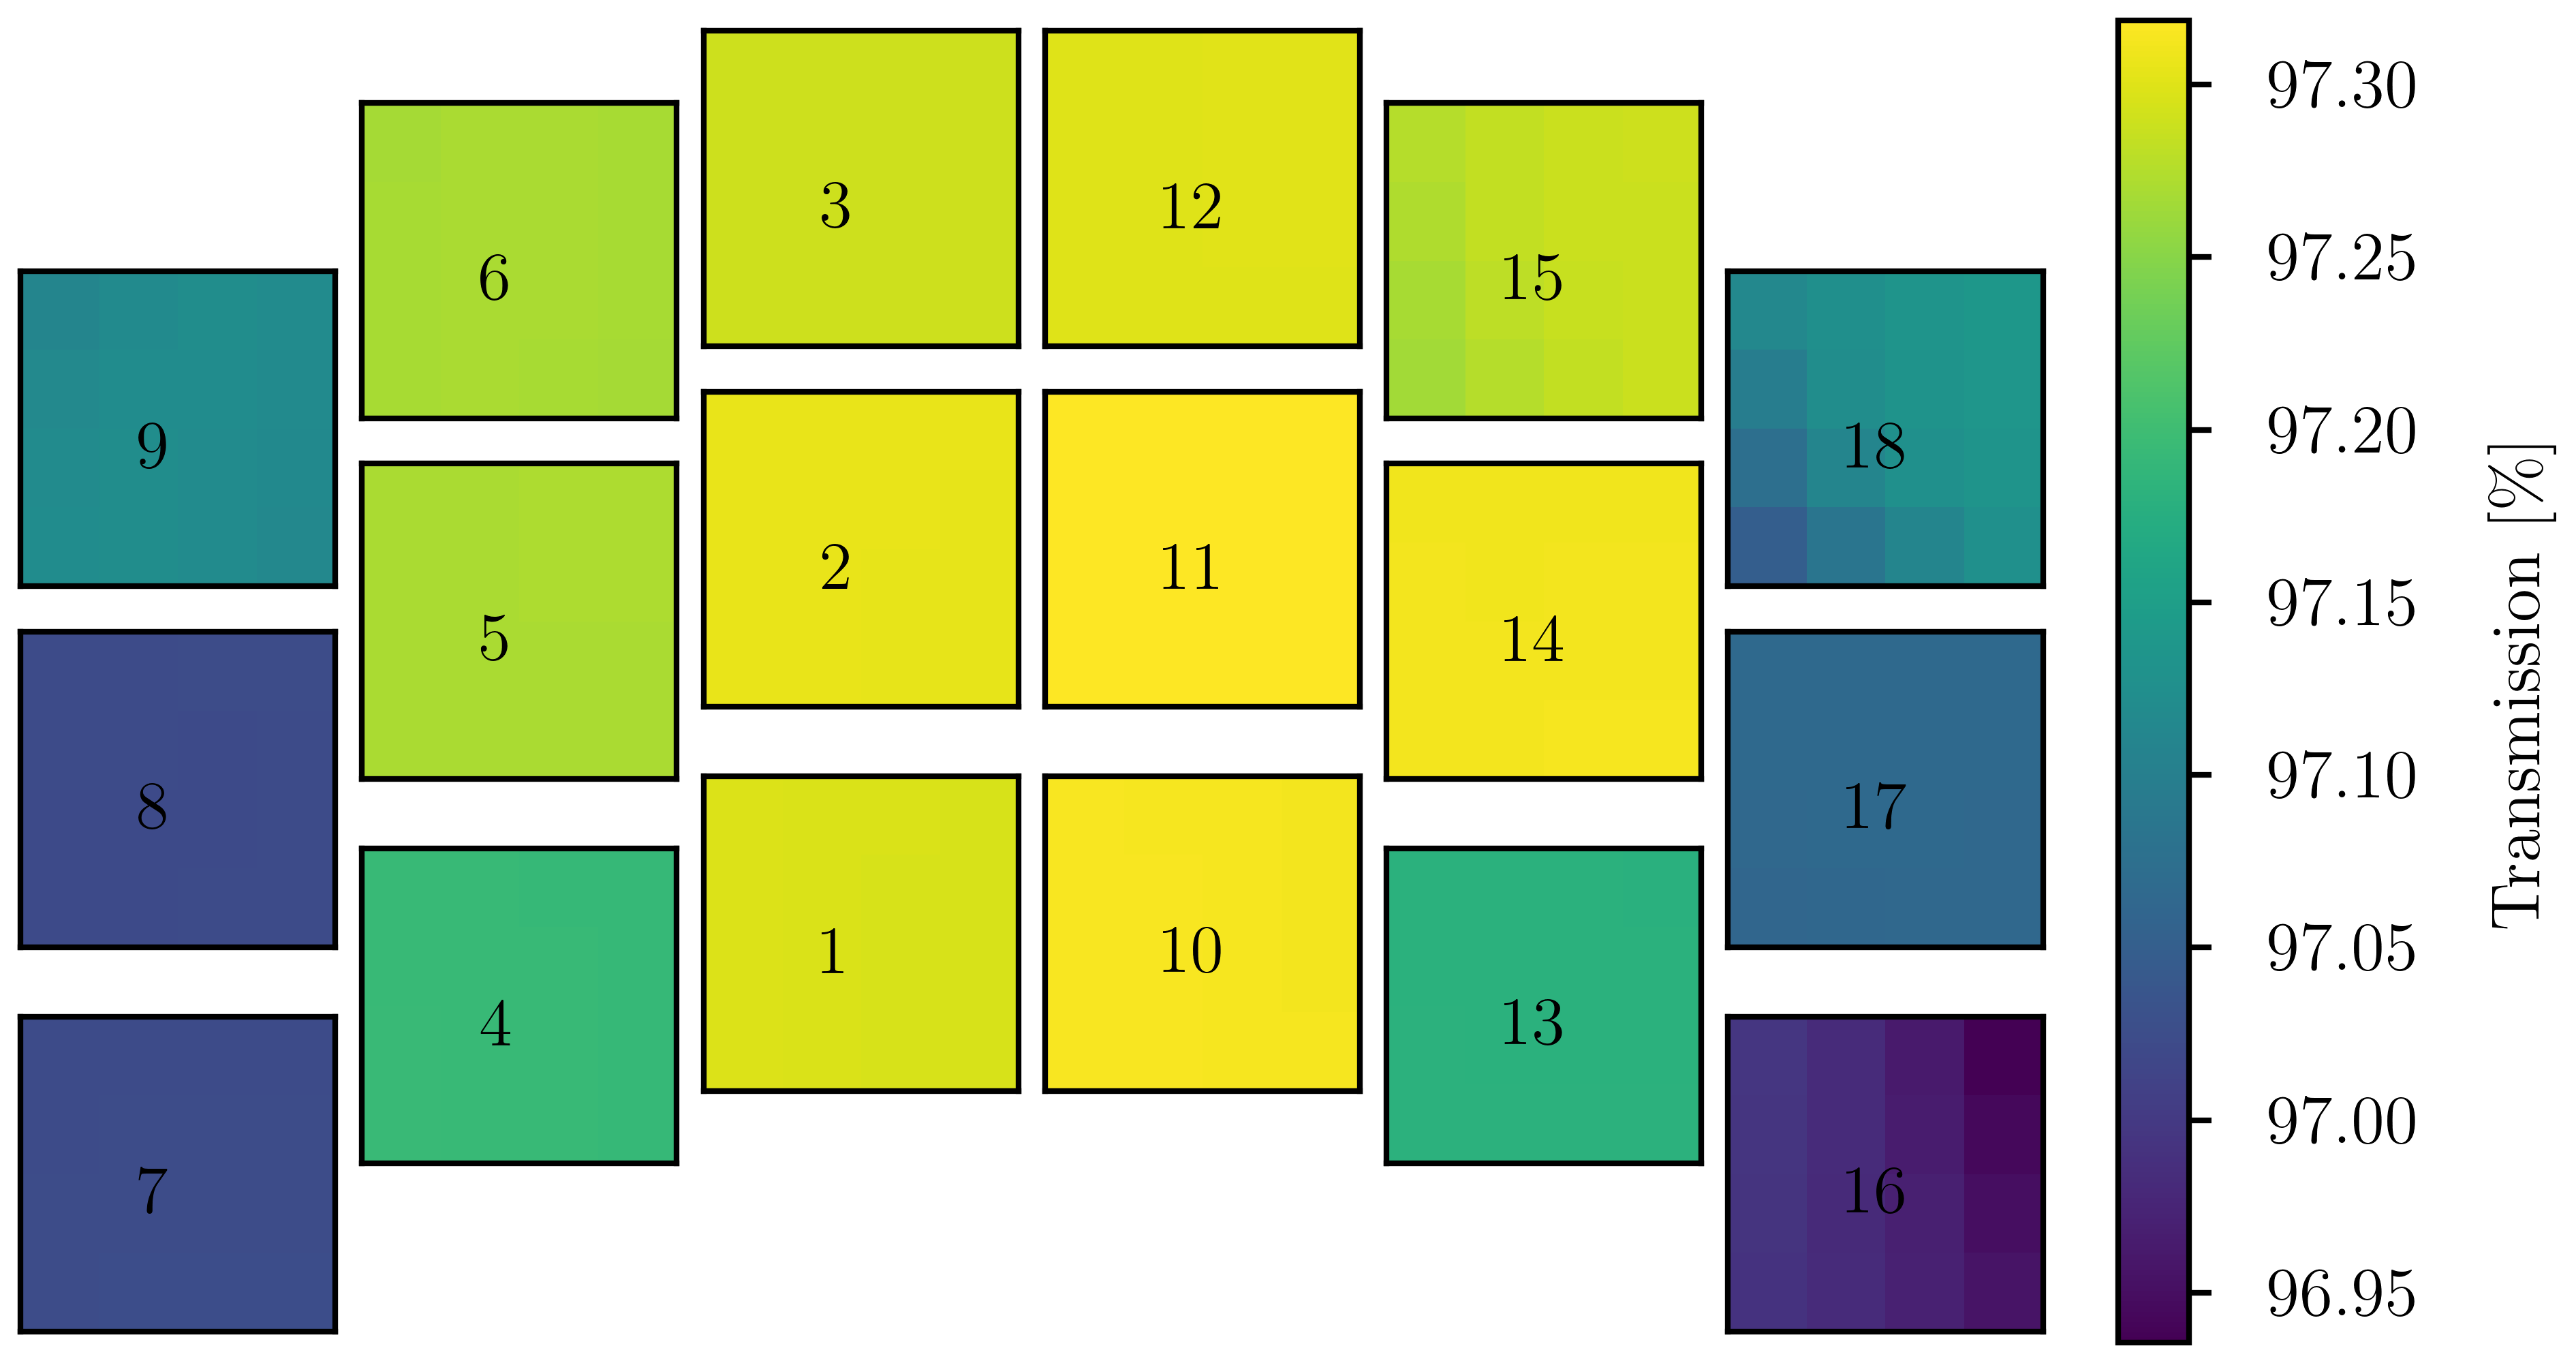

In [9]:
test_array_list = []

k = 0
for sca in range(1, 19):
    array = np.empty((sides, sides))

    for i in range(sides):
        for j in range(sides):
            array[i, j] = transmission[k]
            k += 1

    test_array_list.append(array)

plotting.roman_sca_plot(np.asarray(test_array_list),
                        np.asarray(range(1, 19)),
                        residual_plot=False,
                        show_sca_id=True,
                        cmap='viridis',
                        savefig=True,
                        savepath=os.path.join(figure_dir, 'transmission_across_detectors.png'),
                        clabel='Transmission [\%]')